<a href="https://colab.research.google.com/github/nagusubra/ENDG511_Labs/blob/main/Lab4/ENDG_511_LAB_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENDG 511 Lab 4 Assignment: Advanced Model Optimization**

This colab notebook provides code and a framework for ***Lab 4***. You can work out your solutions here.


## Goals

In this lab, you will be introduced to advanced implmentations of the model optimization methods presented in Lab 3, and you will learn how to use them to create efficient deep learning models. You will also have the opportunity to explore other advanced methods. The goals of this lab are:

- Understand the basics of iterative pruning and how to develop an iterative pruning schedule
- Apply iterative pruning and weight clustering to an MNIST model.
- Become familiar with applying any method of TensorFlow Model Optimization Toolkit's (https://www.tensorflow.org/model_optimization/guide/) by reviewing the examples and implementing them yourself.
- Understand and apply quantization aware training to an MNIST model (optional)

## Layout
This lab is split into **three** parts. 
- **Part 1**: Apply iterative pruning to an MNIST model and evaluate the pruned model.
- **Part 2 (Optional - no marks)**: Apply quantization aware training and evaluate the quantized model.
- **Part 3**: Apply weight clustering alone and then combine weight clustering with iterative pruning.

## How to submit the Assignment 

- You are required to sumbmit the completed python notebook and a pdf version of it in a Dropbox folder on D2L.
- This is an individual assignment, and all the assignements must be submitted individually.
- This assignment can be completed directly on Google Colab, but you are free to choose any other computing resource. 
-  Lab sessions will be held to go over the main concepts and help you with the assignment.

- **Due Date: 31st March**

# **Part 1**: Iterative Pruning

This part of the lab demonstrates applying iterative pruning to a neural network to reduce size and inference while maintaining a high accuracy compared to the original neural network. At a high level, the steps required to implement iterative pruning and evaluate a model are as follows:

- Build and train the dense baseline
- Prune the model (but not till the target sparsity)
- Train the pruned model
- Repeat steps 2 and 3 until the target sparsity is reached.
- Evaluate the final model

One advantage of iterative pruning over one-shot pruning (which was demonstrated in Lab 3) is that it allows for more fine-grained control over the compression process. By retraining the network after each pruning step, the model is able to adapt to the pruning and maintain its performance on the target task. The image below can help you visualize iterative pruning:

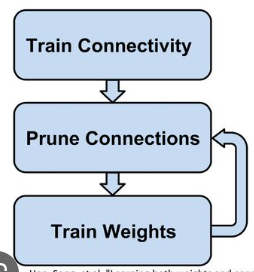

### Import and install all required modules

In [19]:
!pip install -q tensorflow-model-optimization

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from tensorflow import keras
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)

### Build and Train a neural network for MNIST without pruning

Similar to the examples presented in Lab1 we will build and train a neural network for the MNIST dataset without any model optimization. This will be our base model for the remainder of this lab. We also save the model before training - you can choose to use this untrained model in the exercises.


In [2]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Save untrained model
model.save('untrained_base_model.h5')

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_split=0.1,
)

11490434/11490434 [==============================] - 0s 0us/step


Epoch 1/5
1688/1688 [==============================] - 21s 8ms/step - loss: 0.3101 - accuracy: 0.9115 - val_loss: 0.1235 - val_accuracy: 0.9662
Epoch 2/5
1688/1688 [==============================] - 14s 8ms/step - loss: 0.1517 - accuracy: 0.9548 - val_loss: 0.0914 - val_accuracy: 0.9748
Epoch 3/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1138 - accuracy: 0.9660 - val_loss: 0.0786 - val_accuracy: 0.9782
Epoch 4/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0911 - accuracy: 0.9713 - val_loss: 0.0748 - val_accuracy: 0.9778
Epoch 5/5
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0769 - accuracy: 0.9751 - val_loss: 0.0714 - val_accuracy: 0.9793


Let's display the architecture of our model:

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Save model
Let us save the trained model so that we can evaluate it at a later stage.

In [4]:
# Save your trained model
model.save('trained_base_model.h5')

### Define Iterative Pruning Function
We define a function that takes an unpruned model along with other parameteres, performs iterative pruning and returns the pruned model. These are parameters of iterative pruning along with their explanation. 

The **Polynomial Decay** pruning schedule: the degree of sparsity is changed during training and it is not kept constant (as opposted to Lab 3).

**initial_sparsity**: The initial sparsity is the sparsity of the model at the beginning of the iterative pruning procedure. If a none zero value is provided, the model is one-shot pruned to the initial sparsity at the beginning.

**final_sparsity**: This is the final target sparsity of the model.

**begin_step**: The training step where iterative pruning will start to be applied. At this step the model is pruned to the initial sparsity value.

**end_step**: The last training step where iterative pruning will be applied. After this step has been completed the model would have reached its final sparsity.

**frequency**: How often to apply pruning 

**power**: The default is linear. This is the power of the polynomial function and how the sparsity changes from the initial sparsity at the begin step to the final sparsity at the end step

Number of Steps per Epoch = (Total Number of Training Samples) / (Batch Size)

You need to make sure to choose a begin_step and end_step that are not out of the range of the training steps. 


In [5]:
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step, train_images, train_labels, epochs):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(train_images, train_labels, epochs=epochs, validation_split=0.1,
                    callbacks=callbacks)

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  return pruned_model, stripped_pruned_model

In [6]:
pruned_model, stripped_pruned_model = iterative_pruning(model, 0, 0.5, 0, 3000, train_images, train_labels, 3)

Epoch 1/3
1688/1688 [==============================] - 17s 7ms/step - loss: 0.0672 - accuracy: 0.9786 - val_loss: 0.0681 - val_accuracy: 0.9798
Epoch 2/3
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0594 - accuracy: 0.9814 - val_loss: 0.0621 - val_accuracy: 0.9813
Epoch 3/3
1688/1688 [==============================] - 13s 8ms/step - loss: 0.0506 - accuracy: 0.9840 - val_loss: 0.0634 - val_accuracy: 0.9825


In [7]:
stripped_pruned_model.save('stripped_pruned_model.h5')
stripped_pruned_model.save('stripped_pruned_model_saprsity_50.h5')

### Confirm that pruning was correctly applied

In [8]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

dense/kernel:0: 50.00% sparsity  (50176/100352)
dense_1/kernel:0: 50.00% sparsity  (640/1280)


### Evaluate the model
Finally, we compare the pruned model to the base model. We can see that the accuracy and inference time is comparable, however, the pruned model is much smaller in size.

Note: Pruning is capable of improving inference time significantly, however, additional libraries and modifications are needed to see inference improvements as a result of pruning (Pruning inference improvements is very hardware specific!). If you are curious you can read this paper which explains how sparse models can be used to accelerate inference (https://arxiv.org/pdf/1911.09723.pdf)

In [9]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = pruned_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping 
pruned_model_size = get_gzipped_model_size('stripped_pruned_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned50, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.83999919891357 %
Base Model Size: 374820.00 bytes
Base Inference Time is 8.518452644348145e-05 s

Pruned Model Accuracy: 97.97000288963318 %
Pruned Model Size: 234483.00 bytes
Pruned Inference Time is 8.250226974487305e-05 s


### Excercie: (1 points)


####Question 1: 
Apply the iterative pruning function provided above with a final sparsity of 90%. For the paramters of the iterative pruning function choose suitable values that make sense and give reasons for your choices. Compare the accuracy of the iterative pruned 90% model to the one-shot pruned 90% model from Lab3. ***(1 point)***

##### Create iterative pruned model

In [26]:
#INSERT YOUR CODE HERE

# The batch size of the orginal model is 32, because its the default batch size in model.fit in keras.
# The Total Number of Training Samples = 60,000 for the MNIST datatset (https://www.tensorflow.org/datasets/catalog/mnist)

# frquency = 100
# target sparsity = 90%
# sparisty for each pruning tep = 90%/100 = 0.9%
# Total Number of Training Samples = 60,000
# batch size = 32
# epochs = 3

# possible start and end for the iterative pruning schedule
# Number of learning steps = (60,000/32)*3 = 5625 (600, 4500) --- chosen because any epoch higher than 3 did not have a significant performance jump
# Number of learning steps = (60,000/32)*4 = 7500 (750, 6750)
# Number of learning steps = (60,000/32)*5 = 9375 (900, 8000)
# Number of learning steps = (60,000/32)*6 = 11250 (1500, 10000)



# iterative_pruning(
                  #     model, 
                  #     initial_sparsity = 0, 
                  #     final_sparsity   = 0.9, 
                  #     begin_step       = 0, 600  (~10% of 5625) # pruning early on the pruning schedule to get optimal model size
                  #     end_step         = ?, 4500 (~80% of 5625) # pruning only till 80% so that model can still have enough leanring steps to learn and build networks for the data
                  #     train_images, 
                  #     train_labels, 
                  #     epochs           = 3, no change ? since the Number of Steps per Epoch = (Total Number of Training Samples = ?) / (Batch Size = ?) 
                  # )

pruned_model_saprsity_90, stripped_pruned_model_saprsity_90 = iterative_pruning(model, 0, 0.9, 600, 4500, train_images, train_labels, 3)

Epoch 1/3
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0712 - accuracy: 0.9771 - val_loss: 0.0710 - val_accuracy: 0.9792
Epoch 2/3
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1451 - accuracy: 0.9569 - val_loss: 0.1258 - val_accuracy: 0.9673
Epoch 3/3
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2227 - accuracy: 0.9340 - val_loss: 0.1181 - val_accuracy: 0.9697


#####Save model

In [27]:
stripped_pruned_model_saprsity_90.save('stripped_pruned_model_saprsity_90.h5')

#####Sparsity check

In [28]:
print_model_weights_sparsity(stripped_pruned_model_saprsity_90)

dense/kernel:0: 90.00% sparsity  (90317/100352)
dense_1/kernel:0: 90.00% sparsity  (1152/1280)


#####Evaluate the model

In [29]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_90, test_acc_pruned_90 = pruned_model_saprsity_90.evaluate(test_images,  test_labels, verbose=0)

# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_saprsity_90.predict(test_images)
executionTimePruned90 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping 
pruned_model_90_size = get_gzipped_model_size('stripped_pruned_model_saprsity_90.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")


print('\nPruned Model Accuracy:', test_acc_pruned_90*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_90_size))
print("Pruned Inference Time is", executionTimePruned90, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.680002450943 %
Base Model Size: 374917.00 bytes
Base Inference Time is 0.0001403834342956543 s

Pruned Model Accuracy: 96.20000123977661 %
Pruned Model Size: 77396.00 bytes
Pruned Inference Time is 7.962532043457031e-05 s


The one-shot pruned 90% model from Lab3 (screenshot): 

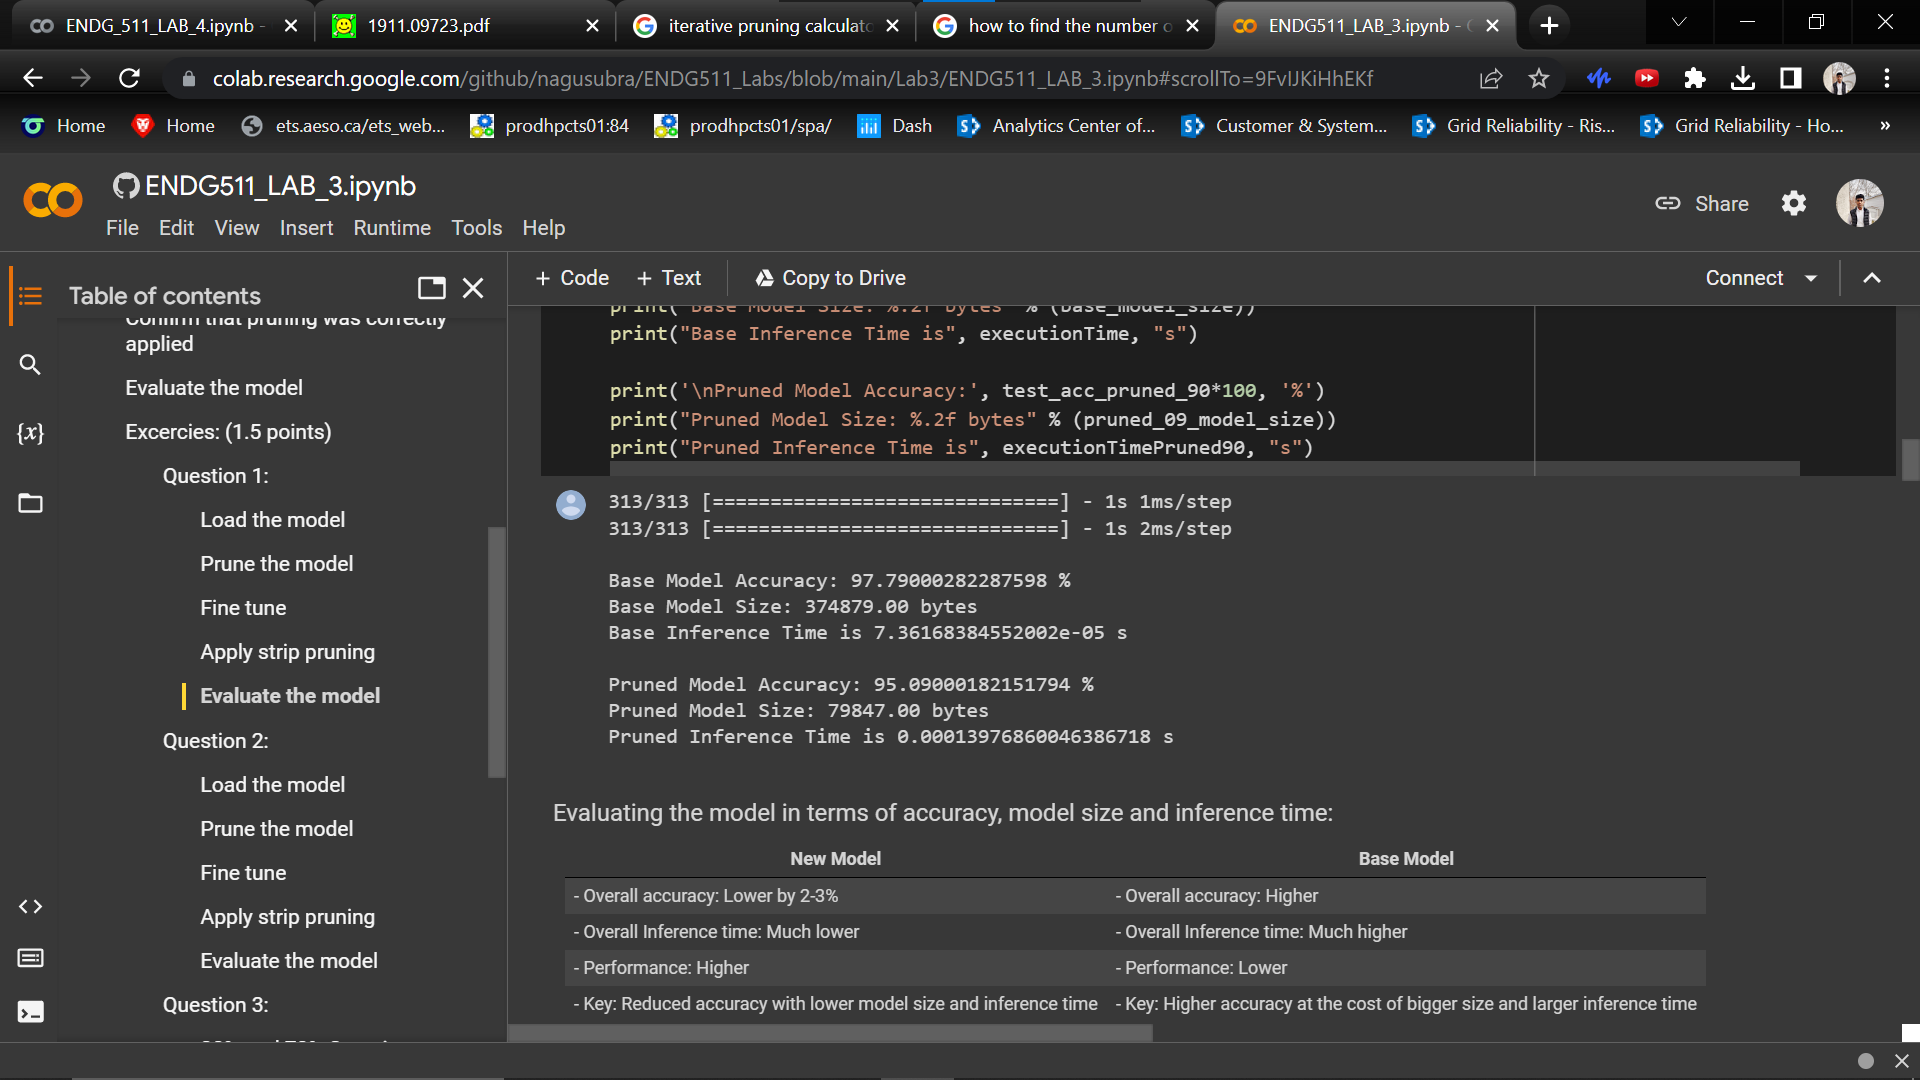

##### Comparison 

The accuracy of the iterative pruned 90% model to the one-shot pruned 90% model from Lab3.

| Lab 3 - 90% sparsity Model | Lab 4 - 90% sparsity Model |
|------------|------------|
| - Overall accuracy: 95.09%| - Overall accuracy: 96.2% (higher accuracy)|
| - Overall model size: 79847.00 bytes| - Overall model size: 77396.00 bytes (smaller size)|
| - Overall Inference time: 0.0001397 s | - Overall Inference time: 7.96e-05 s (lower inference time)|
| - Performance: Lower| - Performance: Higher|
| - Key: It has comparable model size to iterative pruning,| - Key: Iterative pruning proves that we can fine tune our sparsity level, |
|  but significanlty has higher inference time and lower accuracy.| while maintaining our accuracy and inference time|

We can notice that one-shot pruning has a much smaller size than the base model. But the iterative pruning model has an even smaller size than the one-shot pruning model with minimal loss in accuracy.


# **Part 2**:  Quantization Aware Training - Optional (Code Provided)

This part of the lab demonstrates applying quantization aware training to a neural network to reduce size and inference while maintaining a high accuracy. 

In quantization aware training, the quantization process is integrated into the training loop, so the model is optimized to perform well after quantization. This is different from post-training quantization (Lab 3) where quantization is applied in the end after training. This helps to reduce the gap between floating-point and quantized performance, and enables the deployment of deep learning models on low-power, low-memory devices.


At a high level, the steps required to quantize and evaluate a model are as follows:

- Build and train the dense baseline
- Fine tune the model by applying the quantization aware training API, see the accuracy, and export a quantization aware model.
- Apply quantization during conversion to TFLite
- Evaluate the model


Note: a quantization aware model is not actually quantized. Creating a quantized model is a separate step.

### Load base model
First, let us load the base model we have trained earlier.

In [30]:
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
model_to_quantize.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Define Quantization Aware Training function

For quantization aware training, we first train a quantization aware model (from the original trained model) using a subset of the training data. The quantization aware model is then converted to a TFLite model and quantized. The quantized weights are usually more accurate as the model was "quantization aware" prior to the quantization operation.

By default, the TensorFlow QAT APIs assume 8-bit quantization.

In [31]:
def quantization_aware_training(model, x_train, y_train):
    quantize_model = tfmot.quantization.keras.quantize_model

    # q_aware stands for for quantization aware.
    q_aware_model = quantize_model(model)

    # `quantize_model` requires a recompile.
    q_aware_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    q_aware_model.summary()

    train_images_subset = x_train[0:10000] # out of 60000
    train_labels_subset = y_train[0:10000]

    ## Note that the resulting model is quantization aware but not quantized (e.g. the weights are float32 instead of int8)
    q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=5, validation_split=0.1)

    # Note: a quantization aware model is not actually quantized. Creating a quantized model is a separate step.
    ## Convert the quantization aware model to TFLite and apply quantization through the optimization options
    converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    quantized_tflite_model = converter.convert()

    return quantized_tflite_model

In [32]:
quantized_tflite_model = quantization_aware_training(model_to_quantize, train_images, train_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 128)              100485    
 rV2)                                                            
                                                                 
 quant_dropout (QuantizeWrap  (None, 128)              1         
 perV2)                                                          
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1

/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


### Save TFLite model and load model into an interpeter
First we save the TFLite model, this will allow us to load it into an interpreter. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast. 
You can find more information on the TFLite interpeter here: https://www.tensorflow.org/lite/guide/inference

In [33]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

### Evaluate the model
Finally, we evaluate the quantization aware model in terms of accuracy, inference time and model size. There is a very slight difference accuracy compared to Lab3, the reason is the model performs extremely well with post-training quantization that even when doing quantization aware training the benefits are minimal. Furthermore, the model trained is not very complex and therefore the added benefits of QAT are not very evident. For models that see a significant drop in accuracy due to post training quatnization, quantization aware training may be capable of producing better accuracy with no impact to model size or inference time.

In [34]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model.tflite')


Model Accuracy: 97.75 %
Model Size: 81434.00 bytes
Inference Time is 6.198883056640625e-10 s


(0.9775, 81434, 6.198883056640625e-10)

# Part 3: Weight Clustering & Iterative Pruning Compression



There are other common model compression techniques that are constantly being researched and improved upon. Weight clustering is one of them that was discussed in class. There are many websites and research papers that discuss weight clustering including the Deep Compression paper on D2L. In this part of the lab the exercises will be focused on Weight Clustering. Here are two websites that can help you with the lab exercises (Feel free read further papers!).

https://www.tensorflow.org/model_optimization/guide/clustering/clustering_example

https://www.tensorflow.org/model_optimization/guide/combine/sparse_clustering_example



Clustering, or weight sharing, reduces the number of unique weight values in a model, leading to benefits for deployment. It first groups the weights of each layer into N clusters, then shares the cluster's centroid value for all the weights belonging to the cluster.

The two images below highlight how the weights are distributed when 8 clustered are used. The first image is when clustering is done without maintaining sparsity and the second image is when sparsity is maintained (these two methods are discussed in the questions below).

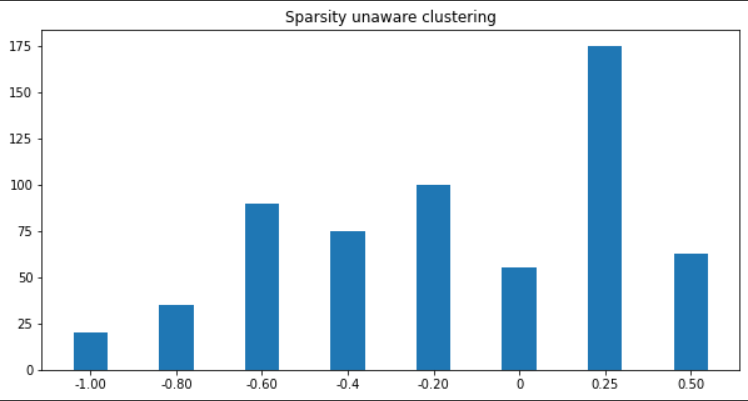

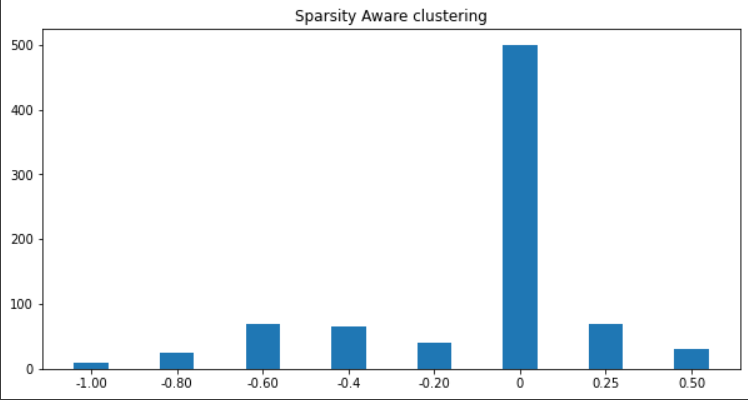

### Exercises (6 points)

###Question 1 (2 points): 

Using the **first** link above and the content of all previous labs, write a function that applies weight clustering. Your function must take in 3 parameters (model, number of clusters and centroid initialization). Experiment and evaluate your model (size and accuracy) with 2 clusters and 16 clusters, and with  KMEANS_PLUS_PLUS centroid initialization and comment on your observations.

##### Weight clustering function

In [34]:
### Insert your code here

def apply_weight_clustering(model, number_of_clusters, centroid_initialization):

  cluster_weights = tfmot.clustering.keras.cluster_weights
  CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

  clustering_params = {
    'number_of_clusters': number_of_clusters,
    'cluster_centroids_init': centroid_initialization,
  }

  print ("clustering_params: ", clustering_params)

  # Cluster a whole model
  clustered_model = cluster_weights(model, **clustering_params)

  # Use smaller learning rate for fine-tuning clustered model
  opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

  clustered_model.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

  clustered_model.summary()

  return clustered_model

In [35]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

##### Train the clustered model

In [36]:
def train_clustered_model(clustered_model, train_images, train_labels, file_text):
  
  clustered_model.fit(
    train_images,
    train_labels,
    epochs=5,
    validation_split=0.1,
  )
  # tf.keras.models.save_model(model, keras_file, include_optimizer=False)
  stripped_clustered_final_model = tfmot.clustering.keras.strip_clustering(clustered_model)
  stripped_clustered_final_model.save('{0}.h5'.format(file_text))
  # return clustered_model
  return clustered_model, stripped_clustered_final_model

##### Run and evaluate the clustered model for 2 clusters

In [37]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

model_to_cluster = tf.keras.models.load_model('trained_base_model.h5')

In [38]:
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
centroid_initialization = CentroidInitialization.KMEANS_PLUS_PLUS
number_of_clusters = int(2)
file_text = "trained_and_clustered_model_2_clusters"


clustered_model_2_clusters = apply_weight_clustering(model_to_cluster, number_of_clusters, centroid_initialization)
clustered_and_trained_model_2_clusters, stripped_clustered_and_trained_model_2_clusters = train_clustered_model(clustered_model_2_clusters, train_images, train_labels, file_text)
clustered_model_loss_2_clusters, clustered_model_accuracy_2_clusters = clustered_and_trained_model_2_clusters.evaluate(test_images,  test_labels, verbose=0)
clustered_model_size_2_clusters = get_gzipped_model_size('trained_and_clustered_model_2_clusters.h5')

print('\nClustered test accuracy:', clustered_model_accuracy_2_clusters*100, '%')
print("Clustered test model size: %.2f bytes" % (clustered_model_size_2_clusters))

clustering_params:  {'number_of_clusters': 2, 'cluster_centroids_init': <CentroidInitialization.KMEANS_PLUS_PLUS: 'CentroidInitialization.KMEANS_PLUS_PLUS'>}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten (ClusterWei  (None, 784)              0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 128)              200834    
 ts)                                                             
                                                                 
 cluster_dropout (ClusterWei  (None, 128)              0         
 ghts)                                                           
                                                                 
 cluster_dense_1 (ClusterWei  (None, 10)               2572      
 ghts)                        


Clustered test accuracy: 11.349999904632568 %
Clustered test model size: 17843.00 bytes


In [43]:
# print_model_weights_sparsity(clustered_and_trained_model_2_clusters)
# print_model_weights_sparsity(stripped_clustered_and_trained_model_2_clusters)

##### Run and evaluate the clustered model for 16 clusters

In [44]:
# Load MNIST dataset again to get errors
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

model_to_cluster = tf.keras.models.load_model('trained_base_model.h5')

In [45]:
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
centroid_initialization = CentroidInitialization.KMEANS_PLUS_PLUS
number_of_clusters = int(16)
file_text = "trained_and_clustered_model_16_clusters"


clustered_model_16_clusters = apply_weight_clustering(model_to_cluster, number_of_clusters, centroid_initialization)
clustered_and_trained_model_16_clusters, stripped_clustered_and_trained_model_16_clusters = train_clustered_model(clustered_model_16_clusters, train_images, train_labels, file_text)
clustered_model_loss_16_clusters, clustered_model_accuracy_16_clusters = clustered_and_trained_model_16_clusters.evaluate(test_images,  test_labels, verbose=0)
clustered_model_size_16_clusters = get_gzipped_model_size('trained_and_clustered_model_16_clusters.h5')

print('\nClustered test accuracy:', clustered_model_accuracy_16_clusters*100, '%')
print("Clustered test model size: %.2f bytes" % (clustered_model_size_16_clusters))


clustering_params:  {'number_of_clusters': 16, 'cluster_centroids_init': <CentroidInitialization.KMEANS_PLUS_PLUS: 'CentroidInitialization.KMEANS_PLUS_PLUS'>}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten (ClusterWei  (None, 784)              0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 128)              200848    
 ts)                                                             
                                                                 
 cluster_dropout (ClusterWei  (None, 128)              0         
 ghts)                                                           
                                                                 
 cluster_dense_1 (ClusterWei  (None, 10)               2586      
 ghts)                       


Clustered test accuracy: 97.4399983882904 %
Clustered test model size: 62717.00 bytes


In [50]:
# print_model_weights_sparsity(clustered_and_trained_model_16_clusters)
# print_model_weights_sparsity(stripped_clustered_and_trained_model_16_clusters)

#####Observations

| Model with 2 clusters | Model with 16 clusters|
|------------|------------|
| - Overall accuracy: 96.39%| - Overall accuracy: 97.71% (higher accuracy)|
| - Overall model size: 22969.00 bytes (smaller size)| - Overall model size: 64704.00 bytes|
| - Key: Since we had only 2 clusters, all the weights are forced to fit in 2 clusters/buckets.| - Key: We have 16 clusters, which is 14 clusters more than the 2 cluster model.|
|  This reduces the model size effectively with minimal accuracy loss.| This increases the model size, while having a better accuracy.|

###Question 2 (1 point): 
Using the resources present above and the content of all previous labs, apply weight clustering with iterative pruning (50% sparsity). Do this by calling your iterative pruning (Part1) followed by your weight clustering functions (of Part-3 Question 1). Print the final sparsity of your model and commment on it, and the performance and size versus what you observed in Q1.


In [52]:
### Insert your code here

# calling the iterative pruning (Part1)
model_to_cluster_and_iteratively_prune = tf.keras.models.load_model('stripped_pruned_model_saprsity_50.h5') # loading the 50% pruned model

# calling weight clustering functions (of Part-3 Question 1)
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
centroid_initialization = CentroidInitialization.KMEANS_PLUS_PLUS
number_of_clusters = int(2) # creating to clusters
file_text = "trained_and_iteratively_pruned_and_clustered_model_2_clusters_question_2"

iteratively_pruned_and_clustered_model_2_clusters = apply_weight_clustering(model_to_cluster_and_iteratively_prune, number_of_clusters, centroid_initialization)
iteratively_pruned_and_clustered_and_trained_model_2_clusters, stripped_iteratively_pruned_and_clustered_and_trained_model_2_clusters = train_clustered_model(iteratively_pruned_and_clustered_model_2_clusters, train_images, train_labels, file_text)
iteratively_pruned_and_clustered_model_loss_2_clusters, iteratively_pruned_and_clustered_model_accuracy_2_clusters = iteratively_pruned_and_clustered_and_trained_model_2_clusters.evaluate(test_images,  test_labels, verbose=0)
iteratively_pruned_and_clustered_model_size_2_clusters = get_gzipped_model_size('trained_and_iteratively_pruned_and_clustered_model_2_clusters_question_2.h5')

print('\nIteratively_pruned_and_clustered test accuracy:', iteratively_pruned_and_clustered_model_accuracy_2_clusters*100, '%')
print("Iteratively_pruned_and_clustered test model size: %.2f bytes" % (iteratively_pruned_and_clustered_model_size_2_clusters))

clustering_params:  {'number_of_clusters': 2, 'cluster_centroids_init': <CentroidInitialization.KMEANS_PLUS_PLUS: 'CentroidInitialization.KMEANS_PLUS_PLUS'>}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten (ClusterWei  (None, 784)              0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 128)              200834    
 ts)                                                             
                                                                 
 cluster_dropout (ClusterWei  (None, 128)              0         
 ghts)                                                           
                                                                 
 cluster_dense_1 (ClusterWei  (None, 10)               2572      
 ghts)                        


Iteratively_pruned_and_clustered test accuracy: 96.21999859809875 %
Iteratively_pruned_and_clustered test model size: 24303.00 bytes


In [53]:
# stripped_iteratively_pruned_and_clustered_model_2_clusters = tf.keras.models.load_model('trained_and_iteratively_pruned_and_clustered_model_2_clusters_question_2.h5')
print_model_weights_sparsity(iteratively_pruned_and_clustered_and_trained_model_2_clusters)

dense/kernel:0: 7.73% sparsity  (7761/100352)
dense_1/kernel:0: 0.00% sparsity  (0/1280)


####Observations

Print the final sparsity of your model and commment on it, and the performance and size versus what you observed in Q1.

| Question 1 model with 2 clusters | Question 2 model with 50% prunde model + 2 clusters  |
|------------|------------|
| - Overall accuracy: 96.67%| - Overall accuracy: 96.21% (higher accuracy)|
| - Overall model size: 25254.00 bytes| - Overall model size: 24303.00 bytes(smaller size)|
| - Key: It has a higher size than the question 2 model,| - Key: It has a lower size and very minimal loss on accuracy than the question 1 model. |
|  This is because it is using the unpruned model.|  This is because it is using the 50% pruned model.|


1. The final sparsity of the model for applying weight clustering with iterative pruning (50% sparsity) is 7.72%.
2. The sparsity is lower than 50% because, when we are clustering the weights without preserving the sparsity, the model essentially has a bunch of weights that was near the zero value. Now, when we cluster the weights into 2 buckets it makes the weights to pool into 2 buckets and it would not lie in the 0 value.
3. This can also be seen in the 2 graphs attached above highlighted how the weights are distributed when 8 clustered are used. We can see that when the sparsity is not preserved, the number of weights lying in 0 is low. Whereas in the sparsity preserving model, it has more number of weights lying at the 0 value.
4. When we have more number of weights lying at the 0 value, we have more sparsity. So, the number of weights with 0 value is proportinal to our sparsity level.
5. Hence, the weight clustering (without preserving sparsity) has lower sparsity since it has lower numbr of weights with a 0 value due to clustering.

###Question 3 (3 points): 
Now apply iterative pruning (50% sparsity) followed by **sparsity preserving clustering** (https://www.tensorflow.org/model_optimization/guide/combine/sparse_clustering_example). 

Print the final sparsity of your model and evaluate your final model. Compare the effects of combining the techniques together vs the techniques individually. Comment on how sparsity-preserving clustering differs from regular weight clustering.

In [23]:
### Insert your code here

# Redoing the wieght clustering pruning with 3 clusters so that its easier to compare with the sparsity preserving clustering.
# This is because the sparsity preserving clustering does not work with 2 or less clusters.

# calling the iterative pruning (Part1)
model_to_cluster_and_iteratively_prune = tf.keras.models.load_model('stripped_pruned_model_saprsity_50.h5') # loading the 50% pruned model

# calling weight clustering functions (of Part-3 Question 1)
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
centroid_initialization = CentroidInitialization.KMEANS_PLUS_PLUS
number_of_clusters = int(3) # creating to clusters
file_text = "trained_and_iteratively_pruned_and_clustered_model_3_clusters_question_2"

iteratively_pruned_and_clustered_model_3_clusters_new = apply_weight_clustering(model_to_cluster_and_iteratively_prune, number_of_clusters, centroid_initialization)
iteratively_pruned_and_clustered_and_trained_model_3_clusters_new, stripped_iteratively_pruned_and_clustered_and_trained_model_3_clusters_new = train_clustered_model(iteratively_pruned_and_clustered_model_3_clusters_new, train_images, train_labels, file_text)
iteratively_pruned_and_clustered_model_loss_3_clusters_new, iteratively_pruned_and_clustered_model_accuracy_3_clusters_new = iteratively_pruned_and_clustered_and_trained_model_3_clusters_new.evaluate(test_images,  test_labels, verbose=0)
iteratively_pruned_and_clustered_model_size_3_clusters_new = get_gzipped_model_size('trained_and_iteratively_pruned_and_clustered_model_3_clusters_question_2.h5')

print('\nIteratively_pruned_and_clustered test accuracy:', iteratively_pruned_and_clustered_model_accuracy_3_clusters_new*100, '%')
print("Iteratively_pruned_and_clustered test model size: %.2f bytes" % (iteratively_pruned_and_clustered_model_size_3_clusters_new))

clustering_params:  {'number_of_clusters': 3, 'cluster_centroids_init': <CentroidInitialization.KMEANS_PLUS_PLUS: 'CentroidInitialization.KMEANS_PLUS_PLUS'>}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten (ClusterWei  (None, 784)              0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 128)              200835    
 ts)                                                             
                                                                 
 cluster_dropout (ClusterWei  (None, 128)              0         
 ghts)                                                           
                                                                 
 cluster_dense_1 (ClusterWei  (None, 10)               2573      
 ghts)                        


Iteratively_pruned_and_clustered test accuracy: 97.15999960899353 %
Iteratively_pruned_and_clustered test model size: 28812.00 bytes


In [24]:
print_model_weights_sparsity(iteratively_pruned_and_clustered_and_trained_model_3_clusters_new)

dense/kernel:0: 8.72% sparsity  (8754/100352)
dense_1/kernel:0: 0.00% sparsity  (0/1280)


In [20]:
### Insert your code here

def apply_sparsity_preserving_clustering(model, number_of_clusters, centroid_initialization):

  # cluster_weights = tfmot.clustering.keras.cluster_weights
  CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

  cluster_weights = cluster.cluster_weights

  clustering_params = {
    'number_of_clusters': number_of_clusters, # tried 2 clusters, but the minimum clusteres that the function takes is 3
    'cluster_centroids_init': centroid_initialization,
    'preserve_sparsity': True
  }
  print ("clustering_params: ", clustering_params)

  clustered_and_pruning_preserved_model = cluster_weights(model, **clustering_params)

  # Use smaller learning rate for fine-tuning clustered model
  # opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

  clustered_and_pruning_preserved_model.compile(  optimizer='adam',
                                                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                                  metrics=['accuracy'])
  clustered_and_pruning_preserved_model.summary()

  return clustered_and_pruning_preserved_model

In [26]:
# calling the iterative pruning (Part1)
model_to_cluster_and_preserve_pruning = tf.keras.models.load_model('stripped_pruned_model_saprsity_50.h5') # loading the 50% pruned model

# calling weight clustering functions (of Part-3 Question 3)
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
centroid_initialization = CentroidInitialization.KMEANS_PLUS_PLUS
number_of_clusters = int(3) # creating to clusters
file_text = "trained_and_iteratively_pruned_and_clustered_model_3_clusters_question_3"

clustered_and_pruning_preserved_model = apply_sparsity_preserving_clustering(model_to_cluster_and_preserve_pruning, number_of_clusters, centroid_initialization)
clustered_and_pruning_preserved_model_trained, clustered_and_pruning_preserved_model_trained_stripped = train_clustered_model(clustered_and_pruning_preserved_model, train_images, train_labels, file_text)
clustered_and_pruning_preserved_model_loss, clustered_and_pruning_preserved_model_accuracy = clustered_and_pruning_preserved_model_trained.evaluate(test_images,  test_labels, verbose=0)
clustered_and_pruning_preserved_model_size = get_gzipped_model_size('trained_and_iteratively_pruned_and_clustered_model_3_clusters_question_3.h5')

print('\nIteratively_pruned_and_clustered test accuracy:', clustered_and_pruning_preserved_model_accuracy*100, '%')
print("Iteratively_pruned_and_clustered test model size: %.2f bytes" % (clustered_and_pruning_preserved_model_size))

clustering_params:  {'number_of_clusters': 3, 'cluster_centroids_init': <CentroidInitialization.KMEANS_PLUS_PLUS: 'CentroidInitialization.KMEANS_PLUS_PLUS'>, 'preserve_sparsity': True}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten (ClusterWei  (None, 784)              0         
 ghts)                                                           
                                                                 
 cluster_dense (ClusterWeigh  (None, 128)              200835    
 ts)                                                             
                                                                 
 cluster_dropout (ClusterWei  (None, 128)              0         
 ghts)                                                           
                                                                 
 cluster_dense_1 (ClusterWei  (None, 10)               2573      
 gh


Iteratively_pruned_and_clustered test accuracy: 97.32999801635742 %
Iteratively_pruned_and_clustered test model size: 31729.00 bytes


In [29]:
print_model_weights_sparsity(clustered_and_pruning_preserved_model_trained)

dense/kernel:0: 50.00% sparsity  (50176/100352)
dense_1/kernel:0: 50.00% sparsity  (640/1280)


##### Observations

Print the final sparsity of your model and evaluate your final model. Compare the effects of combining the techniques together vs the techniques individually. Comment on how sparsity-preserving clustering differs from regular weight clustering.

**The final sparsity of the sparsity conserving model is 50%.**

**Comparing the effects of combining the techniques together vs the techniques individually**

1. The effect of combing the different techniques (iterative pruning + clustering) greatly reduces the model size with minimal loss in accuracy.
2. Throughout the experiments we can see that combining the iterative pruning technique and the sparsity preserving clustering proves to provide better results, where the model size has been reduced with minimal loss in accuracy. Hence we could cobine these various techniques ot reduce our model size effectively.
3. The techniques individually do work well, 

> 1. The Iterative pruning proves that we can fine tune our sparsity level and has lower inference time, while maintaining minimal loss in our accuracy.  Hence iterative pruning proves that it performs better as compared ot the one-shot pruning.

> 2. The Weight clustering effectively pools the weights to the number of clusters we provide. It effectively reduces the model size while suffering minimal loss in accuracy. It also reduces the complexity of the wieghts since we do not have to store complex/large float value as our weights.

> 3. The sparsity preserving clustering effectively clusters the weights while preserving the model's sparsity. This is done by clustrering only the non-zero weights. Hence, this way the sparsity is the same before and after clustering. This way we can reduce the model size and preserve our model sparsity.








**Sparsity-preserving clustering VS regular weight clustering**
1. The sparsity-preserving clustering model is able to preserve the original sparsity of the pruned model, where as the weight clustering model does not.
2. The sparisty preserving clustering clusters only the non-zero weights in the model. Whereas in the regular weight clustering, it clusters all weights regardless of the value.
3. Since we do not cluster the 0 weights, the 0 values remain as is in the model. This can later be seen as the sparsity level. So, later in the model, we can remove those preserved sparse weights without loosing our pruned model sparsity. But, in the regular weight clustering, the model is clustering the 0 weights as well which pulls away some of the 0 values into other buckets/clusters. This way we loose soem of the 0 weights from our pruned model. Hence, this is reflected in the sparsity level of the model as well.